In [1]:
import pandas as pd
import string
import numpy as np
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

In [2]:
df = pd.read_csv('../All_irregular_verb_list.csv', sep=';', encoding='utf-8')
df = df[['First', 'Second', 'Third']]

In [3]:
for column in df.columns[1:]:
    df[column] = df[column].apply(lambda x: re.sub(r'[/.*]', '', x))
    df[column] = df[column].apply(lambda x: re.sub(r'[^a-zA-Z]', '', x))

criteria = df['First'].map(lambda x: len(set(x) & set(string.ascii_uppercase)) == 0)
df = df[criteria]
df = df.reset_index(drop=True)

In [4]:
df[:3]

,First,Second,Third
0,abide,abode,abode
1,arise,arose,arisen
2,awake,awoke,awaked


In [5]:
char_emb = {char: i+1 for i, char in enumerate(string.ascii_lowercase)}
char_emb['0'] = 0

In [6]:
decoder = {val: key for key, val in char_emb.items()}

def decode(idx, decoder):
    return ''.join([decoder[ix] for ix in idx])

In [7]:
max_len = 0
for column_id in range(len(df.columns)):
    for i in range(df.index.size-1):
        if len(df[df.columns[column_id]][i]) > max_len:
            max_len = len(df[df.columns[column_id]][i])

In [8]:
def word2emb(emb, n, word):
    res = np.zeros(n, dtype=int)
    for i, char in enumerate(word):
        res[i] = emb[char]
    return res

for column in df.columns:
    print(column)
    df[column] = df[column].apply(lambda word: word2emb(char_emb, max_len, word))

First
Second
Third


In [9]:
# data, labels = df['First'], df.apply(lambda x: np.hstack((x['Second'], x['Third'])), axis=1)
# data, labels = data.map(lambda x: torch.from_numpy(x)), labels.map(lambda x: torch.from_numpy(x))

data, labels = df['First'], df['Second']
data, labels = data.map(lambda x: torch.from_numpy(x)), labels.map(lambda x: torch.from_numpy(x))

In [10]:
data[:3]

0    [tensor(1), tensor(2), tensor(9), tensor(4), t...
1    [tensor(1), tensor(18), tensor(9), tensor(19),...
2    [tensor(1), tensor(23), tensor(1), tensor(11),...
Name: First, dtype: object

In [11]:
labels[:3]

0    [tensor(1), tensor(2), tensor(15), tensor(4), ...
1    [tensor(1), tensor(18), tensor(15), tensor(19)...
2    [tensor(1), tensor(23), tensor(15), tensor(11)...
Name: Second, dtype: object

In [12]:
EMBEDDING_DIM = 10
HIDDEN_DIM = 10

In [13]:
class LSTMVerbFormer(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(LSTMVerbFormer, self).__init__()
        self.hidden_dim = hidden_dim

        self.char_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        self.hidden2tag = nn.Linear(hidden_dim, vocab_size)

    def forward(self, sentence):
        embeds = self.char_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [14]:
model = LSTMVerbFormer(EMBEDDING_DIM, HIDDEN_DIM, len(char_emb))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [16]:
avg_loss = []

for epoch in tqdm(range(300)): 
    
    running_loss = []
    for sentence, targets in zip(data, labels):
        model.zero_grad()

        tag_scores = model(sentence)

        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
    avg_loss.append(round(sum(running_loss) / len(running_loss), 5))

100%|██████████| 300/300 [03:43<00:00,  1.34it/s]


In [17]:
ix = 100
with torch.no_grad():
    inputs, outputs = data[ix], labels[ix]
    tag_scores = model(inputs)

In [18]:
_, preds = torch.max(tag_scores, 1)

In [19]:
print('{0} => {1}'.format(decode(inputs.tolist(), decoder), decode(preds.tolist(), decoder)))

hurt000000000 => hurt000000000


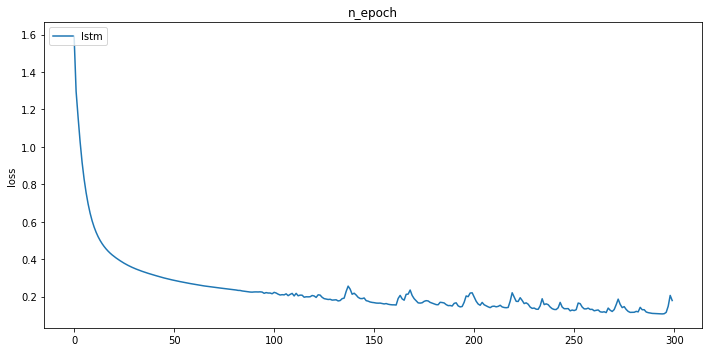

In [20]:
import matplotlib.pyplot as plt

X, Y = range(len(avg_loss)), avg_loss

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(X, Y, label='lstm')
ax.set_title('n_epoch')
ax.legend(loc='upper left')
ax.set_ylabel('loss')
fig.tight_layout()
 
plt.show()

In [21]:
for sentence, target in zip(data, labels):
    with torch.no_grad():
        tag_scores = model(sentence)
        _, preds = torch.max(tag_scores, 1)
        print('{0} => gt: {1}, pred: {2}'.format(re.sub(r'[0.*]', '', decode(sentence.tolist(), decoder)), 
                                                 re.sub(r'[0.*]', '', decode(target.tolist(), decoder)), 
                                                 re.sub(r'[0.*]', '', decode(preds.tolist(), decoder))))

abide => gt: abode, pred: abid
arise => gt: arose, pred: aroso
awake => gt: awoke, pred: awake
backbite => gt: backbitten, pred: backbite
backslide => gt: backslid, pred: backslid
be => gt: was, pred: be
bear => gt: bore, pred: beare
beat => gt: beat, pred: beat
become => gt: became, pred: became
befall => gt: befell, pred: befeld
beget => gt: begot, pred: begot
begin => gt: began, pred: begin
begird => gt: begirt, pred: begirted
behold => gt: beheld, pred: beheld
bend => gt: bent, pred: bent
bereave => gt: bereft, pred: bereaved
beseech => gt: besought, pred: besodchd
beset => gt: beset, pred: besot
bespeak => gt: bespoke, pred: bespeae
bespit => gt: bespat, pred: bespat
bestride => gt: bestrode, pred: bestrode
bet => gt: bet, pred: bet
betake => gt: betook, pred: betoek
bid => gt: bad, pred: bid
bind => gt: bound, pred: biund
bite => gt: bit, pred: bid
bleed => gt: bled, pred: bled
bless => gt: blessed, pred: blessed
blow => gt: blew, pred: blew
break => gt: broke, pred: breae
breed 

wet => gt: wet, pred: wet
win => gt: won, pred: win
wind => gt: wound, pred: winnd
withdraw => gt: withdrew, pred: withdrew
withhold => gt: withheld, pred: withheld
withstand => gt: withstood, pred: withstood
work => gt: worked, pred: worked
wring => gt: wrung, pred: wrong
write => gt: wrote, pred: wrote


In [22]:
ax.savefig('test1.png')

In [23]:
with open('test1.txt', 'w') as f:
    for sentence, target in zip(data, labels):
        with torch.no_grad():
            tag_scores = model(sentence)
            _, preds = torch.max(tag_scores, 1)
            f.write('{0} => gt: {1}, pred: {2}'.format(re.sub(r'[0.*]', '', decode(sentence.tolist(), decoder)), 
                                                     re.sub(r'[0.*]', '', decode(target.tolist(), decoder)), 
                                                     re.sub(r'[0.*]', '', decode(preds.tolist(), decoder))) + '\n')